> Attention Mechanism

Ref: [딥 러닝을 위한 자연어 처리 입문](https://wikidocs.net/22893)

::: {.callout-note}

**my own summary**

현재 디코더의 시점 t에서 단어를 예측하기 위해 인코더의 모든 은닉 상태 각각이 디코더의 현 시점의 은닉 상태와 얼마나 유사한지를 판단하는 스코어 값인 어텐션 스코어를 이용하여 인코더의 문맥context를 포함한 값을 입력으로 넣어 정확도를 높이는 방법

:::

RNN에 기반한 seq2seq 모델의 문제점

1. 하나의 고정된 크기의 벡터에 모든 정보를 압축하려고 하니까 정보 손실이 발생
2. RNN의 고질적인 문제인 기울기 소실 문제 존재

$\to$ 기계 번역 동안 입력 문장이 길면 품질이 떨어지는 현상 발생, 이의 대안으로 입력 시퀀스가 길어지면 출력 시퀀스의 정확도가 떨어지는 것을 보정해주기 위해 들장한 어텐션.

::: {.callout-note}

- 그레디언트 기반의 학습에서 역전파할때 발생하는 문제로 0 근처의 숫자를 계속 곱하여 터지거나 0으로 가는 상황

- 그레디언트 기반의 학습
    - 소실함수의 기울기를 통하여 업데이트하는 방식
- 역전파
    - 손실함수를 여러 단계로 쪼갠다(여러 합성 함수로 표현한다).
    - 각 단계의 미분값을 구한다,
    - 그것들을 모두 곱하여 기울기를 계산한다.

참고: [빅데이터 분석 12주차](https://seoyeonc.github.io/chch/big%20data%20analysis/%EA%B8%B0%EC%9A%B8%EA%B8%B0%EC%86%8C%EB%A9%B8/%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C/2022/01/23/bd-12%EC%A3%BC%EC%B0%A8.html)

:::

# Attention Function

```{mermaid}
flowchart LR
    subgraph "Source"
        subgraph B2
            direction BT
            Key1 --> Value1
            Key2 --> Value2
            Key3 --> Value3
        end
    end
  Query --> Source --> Attention\nValue
```

$$Attention(Q, K, V) = \text{Attention Value}$$

1. 주어진 쿼리에 대해서 모든 키와의 유사도를 각각 구한다.
2. 구한 유사도를 키와 맵핑되어 있는 각각의 값value에 반영한다.
3. 유사도가 반영된 값을 모두 더해서 리턴한다. 여기서 값 = **어텐션 값 attention value**

### 어텐션 모델의 요소

- `Q`= Query 
    - t 시점의 디코더 셀에서의 은닉 상태
- `K` = Keys
    - 모든 시점의 인코더 셀의 은닉 상태들
- `V` = Values
    - 모든 시점의 인코더 셀의 은닉 상태들

## Dot-Product Attention

- 디코더의 마지막 LSTM 셀이 출력단어를 예측하기 위해 인코더의 모든 입력 단어들의 정보를 다시 참고하고자 함
- 이 때, 소프트 맥스를 이용
    - 인코더에 입력된 값들이 출력 단어를 예측할 때 얼마나 도움이 되었는지 수치화한 결과
    - 다시 디코더로 전달
    - 디코더가 출력 단어를 더 정확하게 예측하게 도와줌

### 1. 어텐션 스코어를 구한다.

- 인코더의 은닉 시점 time stamp = $1,2, \dots, N$
- 인코더의 은닉 상태 hidden state = $s_t$
    - 단, 인코더와 디코더의 은닉 상태는 차원이 같음

::: {.callout-important}

디코더의 현재시점 t에서 필요한 입력값

seq2seq

- 이전 시점인 t-1의 은닉 상태
- 이전 시점 t-1에서 나온 출력 단어

attention

- 이전 시점인 t-1의 은닉 상태
- 이전 시점 t-1에서 나온 출력 단어
- 어텐션 값 $a_t$

:::


**attention score 어텐션 값**

- 현재 디코더의 시점 t에서 단어를 예측하기 위해 인코더의 모든 은닉 상태 각각이 디코더의 현 시점의 은닉 상태 $s_t$와 얼마나 유사한지를 판단하는 스코어 값

닷 프로덕트 어텐션은 은닉 상태 $s_t$를 전치(transpose)하고, 각 은닉 상태와 내적(dot product)를 수행하여 스칼라 결과 어텐션 스코어 score 추출

- **닷 프러덕트 어텐션이라고 부르는 이유**

$$score(s_t, h_i) = s_t^\top h_i$$

$$e^t = [s_t^\top h_1, \dots, s_t^\top h_N]$$

$e^t$는 $s_t$와 인코더의 모든 은닉 상태의 어텐션 스코어의 모음값

### 2. 소프트맥스 함수를 통해 어텐션 분포를 구한다.

- $e^t$에 소프트맥스 함수 적용해서 합이 1이 되는 확률 분포 도출
    - 각각 값은 어텐션 가중치 Attention weight
    - 분포는 어텐션 분포 Attention Distribution $\alpha^t$

$$\alpha^t = softmax(e^t)$$

### 3. 각 인코더의 어텐션 가중치와 은닉 상태를 가중합하여 어텐션 값을 구한다.

- 어텐션의 최종 결과값을 얻기 위해 각 인코더의 은닉상태 $s_t$와 어텐션 가중치 값attention weight를 곱하고 가중합weighted sum인 어텐션 값attention value $a_t$을 구한다.

$$a_t = \sum^N_{i=1} \alpha_i^t h_i$$

::: {.callout-tip}

어텐션 값 attention value $a_t$는 인코더의 문맥을 포함하고 있다고 하여 컨텐스트 벡터 context vector라고도 부른다.

단, seq2seq에서는 인코더의 마지막 은닉 상태를 컨텍스트 벡터context vector라고 불렀음.

:::

### 4. 어텐션 값과 디코더의 t 시점의 은닉 상태를 연결한다.

- 어텐션 값$a_t$와 디코더의 은닉 상태 $s_t$를 결합concatenate하여 하나의 벡터로 만드는 작업을 수행한다. $\to$ $v_t$
- 아 $v_t$를 예측 연산의 입력으로 사용함으로써 인코더로부터 얻은 정보를 활용하여 $\hat{y}$를 더 잘 예측할 수 있게 됨 $\to$ 어텐션 메커니즘의 핵심

### 5. 출력층 연산의 입력이 되는 $\tilde{s}_t$를 계산한다.

- 어텐션 값과 디코더의 t시점의 은닉 상태를 연결하고$a_t s_t$ tanh하이퍼볼릭탄젠트 함수를 통과하도록 해서 출력층 연산을 위한 새로운 벡터 $\tilde{s}_t$를 얻는다.

::: {.callout-note}

seq2seq

- 출력층의 입력이 t시점의 은닉 상태인 $s_t$

attention

- 출력층의 입력이 $\tilde{s}_t$

:::


$$\tilde{s}_t = tanh(W_c[a_t;s_t] + b_c$$

$b_c$는 편향

참고: [기계학습 특강 9주차 tanh](https://seoyeonc.github.io/chch/special%20topics%20in%20machine%20learning/%EC%88%9C%ED%99%98%EC%8B%A0%EA%B2%BD%EB%A7%9D/embedding%20layer/2022/11/02/ml_(9%EC%A3%BC%EC%B0%A8)_10%EC%9B%9431%EC%9D%BC.html)

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
tanh = torch.nn.Tanh()

Text(0.5, 1.0, 'tanh(x)')

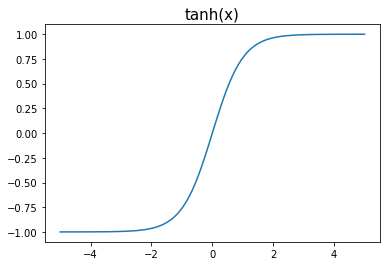

In [3]:
_x = torch.linspace(-5,5,100)
plt.plot(_x,tanh(_x))
plt.title("tanh(x)", size=15)

### 6. $\tilde{s}_t$를 출력층의 입력으로 사용한다.

$$\hat{y}_t = Softmax(W_y \tilde{s}_t + b_y)$$

# 다양한 종류의 어텐션

$s_t$는 query, $h_i$는 keys, $W_a$, $W_b$는 학습 가능한 가중치 행렬

| 이름 | 스코어 함수 | defined by | 
|---------|:-----|:------|
| dot      | $score(s_t,h_i) = s_t^\top h_i$   |    Luong et al. (2015) |  
| scaled dot     | $score(s_t,h_i) = \frac{s_t^\top h_i}{\sqrt{n}}$  |   Vaswani et al. (2017) |  
| general       | $score(s_t,h_i) = s_t^\top W_a h_i$ 단, $W_a$는 학습 가능한 가중치 행렬    | Luong et al. (2015)|  
| concat| $score(s_t, h_i) = W_a^\top tanh(W_b[s_t;h_i]),score(s_t,h_i) = W_a^\top tanh(W_b s_t + W_c h_i)$| Bahdanau et al. (2015) |  
| location-base       | $\alpha_t = softmax(W_a s_t)$ $\alpha_t$ 산출 시에 $s_t$만 사용하는 방법    |    Luong et al. (2015) |  